In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

In [2]:
dataset_ruta = r'D:\Documentos\IPN\6to Semestre\Aprendizaje_profundo\programas\proyecto'

## Dataset en tf

In [3]:
# Cargar metadata generado anteriormente
df_mel = pd.read_csv(dataset_ruta + r"\mel_metadata.csv")
df_mel.head()

# Cargar el CSV original del dataset
metadata_path = os.path.join(dataset_ruta, "data", "UrbanSound8K.csv")
df_original = pd.read_csv(metadata_path)

# Crear diccionario {classID: class}
class_dict = dict(zip(df_original["classID"], df_original["class"]))
print("Diccionario de clases:")
print(class_dict)

# Añadir columna con el nombre de clase
df_mel["class_name"] = df_mel["label"].map(class_dict)

df_mel.head()


Diccionario de clases:
{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}


,spectrogram,label,class_name
0,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,3,dog_bark
1,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing
2,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing
3,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing
4,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,2,children_playing


In [4]:
df_mel = df_mel.drop(columns=["label"])
df_mel.head()

,spectrogram,class_name
0,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,dog_bark
1,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing
2,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing
3,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing
4,D:\Documentos\IPN\6to Semestre\Aprendizaje_pro...,children_playing


In [5]:
# Crear lista ordenada de clases
class_names = sorted(df_mel["class_name"].unique())
num_classes = len(class_names)

print("Clases:", class_names)
print("Número de clases:", num_classes)

# Conversión de texto → índice entero
string_lookup = tf.keras.layers.StringLookup(vocabulary=class_names, num_oov_indices=0, output_mode="int")

Clases: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
Número de clases: 10


In [6]:
train_df, temp_df = train_test_split(
    df_mel, 
    test_size=0.20, 
    random_state=42, 
    stratify=df_mel["class_name"]
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.50, 
    random_state=42, 
    stratify=temp_df["class_name"]
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 6985
Val: 873
Test: 874


In [7]:
# Cargar espectograma
def load_mel_only(path):
    mel = np.load(path.decode("utf-8")).astype(np.float32)
    return mel

In [8]:
# Wrapper para usar en tf.data
def tf_load_mel(path, label_str):

    mel = tf.numpy_function(load_mel_only, [path], tf.float32)
    mel.set_shape((128, 128, 1))

    label_int = string_lookup(label_str)

    return mel, label_int

In [9]:
# ---------------------------
# Creación de tf.data.Dataset
# ---------------------------
batch_size = 16

# TRAIN
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["spectrogram"].values, train_df["class_name"].values)
)
train_ds = train_ds.map(tf_load_mel, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# VALIDATION
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["spectrogram"].values, val_df["class_name"].values)
)
val_ds = val_ds.map(tf_load_mel, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# TEST
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["spectrogram"].values, test_df["class_name"].values)
)
test_ds = test_ds.map(tf_load_mel, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
def time_mask(mel, max_mask=20):
    mel = tf.identity(mel)
    f, t, c = tf.shape(mel)[0], tf.shape(mel)[1], tf.shape(mel)[2]

    mask_size = tf.random.uniform([], 0, max_mask, dtype=tf.int32)
    mask_size = tf.minimum(mask_size, t)
    t0 = tf.random.uniform([], 0, t - mask_size, dtype=tf.int32)

    mask = tf.ones([f, mask_size, c], dtype=mel.dtype)
    mask = tf.pad(mask, [[0,0], [t0, t - t0 - mask_size], [0,0]], constant_values=0)
    return mel * (1 - mask)


def freq_mask(mel, max_mask=20):
    mel = tf.identity(mel)
    f, t, c = tf.shape(mel)[0], tf.shape(mel)[1], tf.shape(mel)[2]

    mask_size = tf.random.uniform([], 0, max_mask, dtype=tf.int32)
    mask_size = tf.minimum(mask_size, f)
    f0 = tf.random.uniform([], 0, f - mask_size, dtype=tf.int32)

    mask = tf.ones([mask_size, t, c], dtype=mel.dtype)
    mask = tf.pad(mask, [[f0, f - f0 - mask_size], [0,0], [0,0]], constant_values=0)
    return mel * (1 - mask)


def random_gain(mel, min_gain=0.8, max_gain=1.2):
    gain = tf.random.uniform([], min_gain, max_gain)
    return mel * gain

def time_shift(mel, max_shift=10):
    shift = tf.random.uniform([], -max_shift, max_shift, dtype=tf.int32)
    return tf.roll(mel, shift=shift, axis=1)

def augment_mel(mel, label):
    orig_shape = mel.shape  # shape estática esperada
    
    mel = time_mask(mel, max_mask=15)
    mel = freq_mask(mel, max_mask=15)
    mel = random_gain(mel)
    mel = time_shift(mel, max_shift=8)

    mel = tf.ensure_shape(mel, orig_shape)  #fuerza a que el output tenga la misma forma
    return mel, label


In [11]:
# Aplicamos el data augmentation
#train_ds = train_ds.map(augment_mel, num_parallel_calls=tf.data.AUTOTUNE)

Batch MEL shape: (16, 128, 128, 1)
Batch labels (índices): [3 2 0 4 7 8 3 3 0 3]


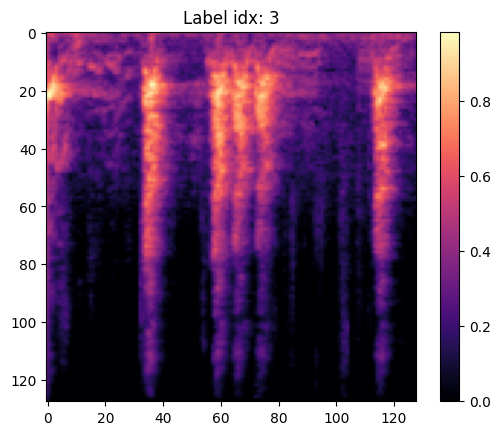

In [12]:
import matplotlib.pyplot as plt 

# Verificación visual de un batch
mel_batch, label_batch = next(iter(train_ds))

print("Batch MEL shape:", mel_batch.shape)
print("Batch labels (índices):", label_batch.numpy()[:10])

plt.imshow(mel_batch[0].numpy().squeeze(), cmap="magma")
plt.title(f"Label idx: {label_batch[0].numpy()}")
plt.colorbar()
plt.show()

In [13]:
mel_batch, label_batch = next(iter(train_ds))
print("Mín etiqueta:", label_batch.numpy().min())
print("Máx etiqueta:", label_batch.numpy().max())

Mín etiqueta: 0
Máx etiqueta: 9


## Entrenamiento

In [14]:
from tensorflow.keras import layers, models

In [15]:
def build_crnn_model(input_shape=(128,128,1), num_classes=10):

    inputs = layers.Input(shape=input_shape)

    # CNN
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)  # → (16,16,128)

    # TimeDistributed pooling
    x = layers.Permute((2,1,3))(x)  # (batch, time, freq, channels)

    x = layers.TimeDistributed(layers.GlobalAveragePooling1D())(x)
    # → (batch, time=16, features=128)

    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3))(x)

    # Dense
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [16]:
# Creación del modelo
model = build_crnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 128)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,290 (786.29 KB)

 Trainable params: 200,842 (784.54 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
# Compilación del modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [18]:
# Definición de callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),

    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6
    ),

    tf.keras.callbacks.ModelCheckpoint(
        "crnn_urbansound8k.h5",
        monitor="val_loss",
        save_best_only=True
    )
]

In [19]:
# -------------------------
# Entrenamiento del modelo
# -------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.2768 - loss: 1.9631

437/437 ━━━━━━━━━━━━━━━━━━━━ 424s 907ms/step - accuracy: 0.3482 - loss: 1.7580 - val_accuracy: 0.2405 - val_loss: 2.3254 - learning_rate: 0.0010
Epoch 2/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 215s 463ms/step - accuracy: 0.5145 - loss: 1.3075 - val_accuracy: 0.2703 - val_loss: 2.4971 - learning_rate: 0.0010
Epoch 3/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6073 - loss: 1.1055

437/437 ━━━━━━━━━━━━━━━━━━━━ 211s 481ms/step - accuracy: 0.6242 - loss: 1.0710 - val_accuracy: 0.4318 - val_loss: 1.8010 - learning_rate: 0.0010
Epoch 4/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 204s 465ms/step - accuracy: 0.6732 - loss: 0.9318 - val_accuracy: 0.3001 - val_loss: 3.2027 - learning_rate: 0.0010
Epoch 5/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 210s 480ms/step - accuracy: 0.7314 - loss: 0.8007 - val_accuracy: 0.5212 - val_loss: 1.8591 - learning_rate: 0.0010
Epoch 6/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7640 - loss: 0.7190

437/437 ━━━━━━━━━━━━━━━━━━━━ 206s 470ms/step - accuracy: 0.7691 - loss: 0.7000 - val_accuracy: 0.4834 - val_loss: 1.7664 - learning_rate: 0.0010
Epoch 7/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 457ms/step - accuracy: 0.7934 - loss: 0.6354 - val_accuracy: 0.2967 - val_loss: 3.2727 - learning_rate: 0.0010
Epoch 8/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8203 - loss: 0.5648

437/437 ━━━━━━━━━━━━━━━━━━━━ 198s 452ms/step - accuracy: 0.8163 - loss: 0.5602 - val_accuracy: 0.5785 - val_loss: 1.3884 - learning_rate: 0.0010
Epoch 9/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 460ms/step - accuracy: 0.8332 - loss: 0.5121 - val_accuracy: 0.6071 - val_loss: 1.8149 - learning_rate: 0.0010
Epoch 10/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 205s 469ms/step - accuracy: 0.8587 - loss: 0.4422 - val_accuracy: 0.5315 - val_loss: 1.6067 - learning_rate: 0.0010
Epoch 11/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8675 - loss: 0.4247

437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 457ms/step - accuracy: 0.8676 - loss: 0.4175 - val_accuracy: 0.7320 - val_loss: 0.9034 - learning_rate: 0.0010
Epoch 12/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 202s 462ms/step - accuracy: 0.8674 - loss: 0.4114 - val_accuracy: 0.5842 - val_loss: 1.6792 - learning_rate: 0.0010
Epoch 13/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 199s 453ms/step - accuracy: 0.8785 - loss: 0.3834 - val_accuracy: 0.5670 - val_loss: 1.5626 - learning_rate: 0.0010
Epoch 14/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 198s 452ms/step - accuracy: 0.8925 - loss: 0.3390 - val_accuracy: 0.5349 - val_loss: 1.6929 - learning_rate: 0.0010
Epoch 15/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9042 - loss: 0.2899

437/437 ━━━━━━━━━━━━━━━━━━━━ 203s 463ms/step - accuracy: 0.9141 - loss: 0.2658 - val_accuracy: 0.8648 - val_loss: 0.4292 - learning_rate: 5.0000e-04
Epoch 16/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 456ms/step - accuracy: 0.9280 - loss: 0.2316 - val_accuracy: 0.5567 - val_loss: 2.2606 - learning_rate: 5.0000e-04
Epoch 17/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 199s 455ms/step - accuracy: 0.9354 - loss: 0.2115 - val_accuracy: 0.6690 - val_loss: 1.4812 - learning_rate: 5.0000e-04
Epoch 18/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.9290 - loss: 0.2239

437/437 ━━━━━━━━━━━━━━━━━━━━ 204s 464ms/step - accuracy: 0.9321 - loss: 0.2093 - val_accuracy: 0.8820 - val_loss: 0.3691 - learning_rate: 5.0000e-04
Epoch 19/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 199s 455ms/step - accuracy: 0.9409 - loss: 0.1948 - val_accuracy: 0.8866 - val_loss: 0.4073 - learning_rate: 5.0000e-04
Epoch 20/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9456 - loss: 0.1714

437/437 ━━━━━━━━━━━━━━━━━━━━ 198s 453ms/step - accuracy: 0.9417 - loss: 0.1818 - val_accuracy: 0.8889 - val_loss: 0.3514 - learning_rate: 5.0000e-04
Epoch 21/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 457ms/step - accuracy: 0.9453 - loss: 0.1639 - val_accuracy: 0.5991 - val_loss: 1.8248 - learning_rate: 5.0000e-04
Epoch 22/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 212s 484ms/step - accuracy: 0.9490 - loss: 0.1593 - val_accuracy: 0.8637 - val_loss: 0.5470 - learning_rate: 5.0000e-04
Epoch 23/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 216s 484ms/step - accuracy: 0.9486 - loss: 0.1559 - val_accuracy: 0.7847 - val_loss: 0.9741 - learning_rate: 5.0000e-04
Epoch 24/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9566 - loss: 0.1238

437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 456ms/step - accuracy: 0.9601 - loss: 0.1180 - val_accuracy: 0.9336 - val_loss: 0.2324 - learning_rate: 2.5000e-04
Epoch 25/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 455ms/step - accuracy: 0.9636 - loss: 0.1122 - val_accuracy: 0.9187 - val_loss: 0.2732 - learning_rate: 2.5000e-04
Epoch 26/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 202s 462ms/step - accuracy: 0.9692 - loss: 0.0971 - val_accuracy: 0.8900 - val_loss: 0.4683 - learning_rate: 2.5000e-04
Epoch 27/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 202s 460ms/step - accuracy: 0.9645 - loss: 0.1040 - val_accuracy: 0.9049 - val_loss: 0.3745 - learning_rate: 2.5000e-04
Epoch 28/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9691 - loss: 0.0932

437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 459ms/step - accuracy: 0.9718 - loss: 0.0879 - val_accuracy: 0.9381 - val_loss: 0.2234 - learning_rate: 1.2500e-04
Epoch 29/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9715 - loss: 0.0866

437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 458ms/step - accuracy: 0.9719 - loss: 0.0827 - val_accuracy: 0.9462 - val_loss: 0.2159 - learning_rate: 1.2500e-04
Epoch 30/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 459ms/step - accuracy: 0.9754 - loss: 0.0726 - val_accuracy: 0.9336 - val_loss: 0.2504 - learning_rate: 1.2500e-04
Epoch 31/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 459ms/step - accuracy: 0.9754 - loss: 0.0787 - val_accuracy: 0.9255 - val_loss: 0.2749 - learning_rate: 1.2500e-04
Epoch 32/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 199s 453ms/step - accuracy: 0.9768 - loss: 0.0701 - val_accuracy: 0.9381 - val_loss: 0.2269 - learning_rate: 1.2500e-04
Epoch 33/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9768 - loss: 0.0667

437/437 ━━━━━━━━━━━━━━━━━━━━ 206s 470ms/step - accuracy: 0.9785 - loss: 0.0680 - val_accuracy: 0.9439 - val_loss: 0.2056 - learning_rate: 6.2500e-05
Epoch 34/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 202s 460ms/step - accuracy: 0.9790 - loss: 0.0659 - val_accuracy: 0.9450 - val_loss: 0.2245 - learning_rate: 6.2500e-05
Epoch 35/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 459ms/step - accuracy: 0.9795 - loss: 0.0639 - val_accuracy: 0.9462 - val_loss: 0.2148 - learning_rate: 6.2500e-05
Epoch 36/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 206s 471ms/step - accuracy: 0.9832 - loss: 0.0561 - val_accuracy: 0.9450 - val_loss: 0.2197 - learning_rate: 6.2500e-05
Epoch 37/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 202s 462ms/step - accuracy: 0.9808 - loss: 0.0613 - val_accuracy: 0.9473 - val_loss: 0.2118 - learning_rate: 3.1250e-05
Epoch 38/40
437/437 ━━━━━━━━━━━━━━━━━━━━ 200s 455ms/step - accuracy: 0.9802 - loss: 0.0610 - val_accuracy: 0.9450 - val_loss: 0.2161 - learning_rate: 3.1250e-05


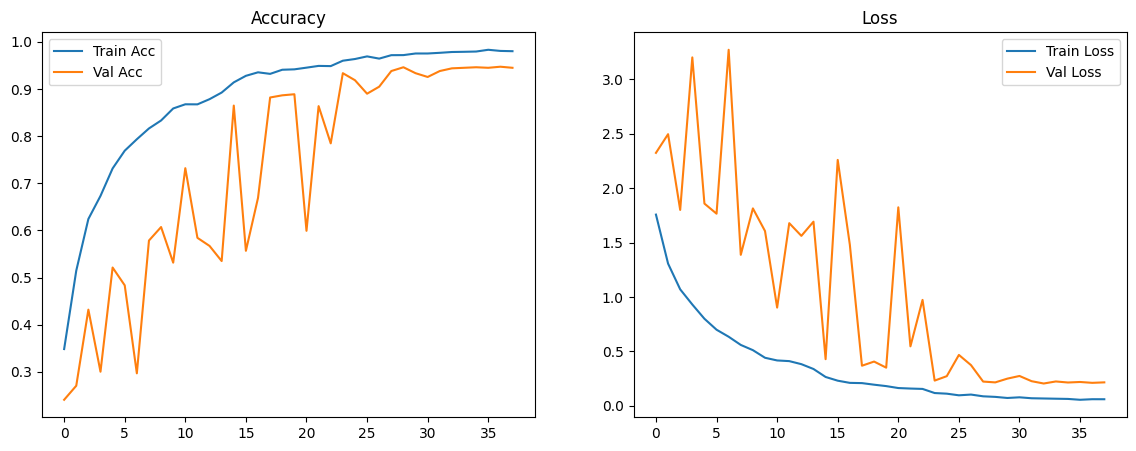

In [20]:

# Graficamos
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

## Evaluación

In [21]:
# Obtener predicciones del modelo
y_true = []
y_pred = []
y_prob = []

for mel_batch, label_batch in test_ds:
    probs = model.predict(mel_batch)
    preds = np.argmax(probs, axis=1)

    y_true.extend(label_batch.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [22]:
from sklearn.metrics import classification_report, accuracy_score

# Generar el reporte de métricas de evaluación
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.9610983981693364

Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.96      0.98      0.97       100
        car_horn       0.98      0.93      0.95        43
children_playing       0.93      0.93      0.93       100
        dog_bark       0.97      0.99      0.98       100
        drilling       0.95      0.98      0.97       100
   engine_idling       0.99      0.97      0.98       100
        gun_shot       1.00      0.97      0.99        38
      jackhammer       0.97      0.96      0.96       100
           siren       0.99      0.91      0.95        93
    street_music       0.92      0.97      0.94       100

        accuracy                           0.96       874
       macro avg       0.97      0.96      0.96       874
    weighted avg       0.96      0.96      0.96       874



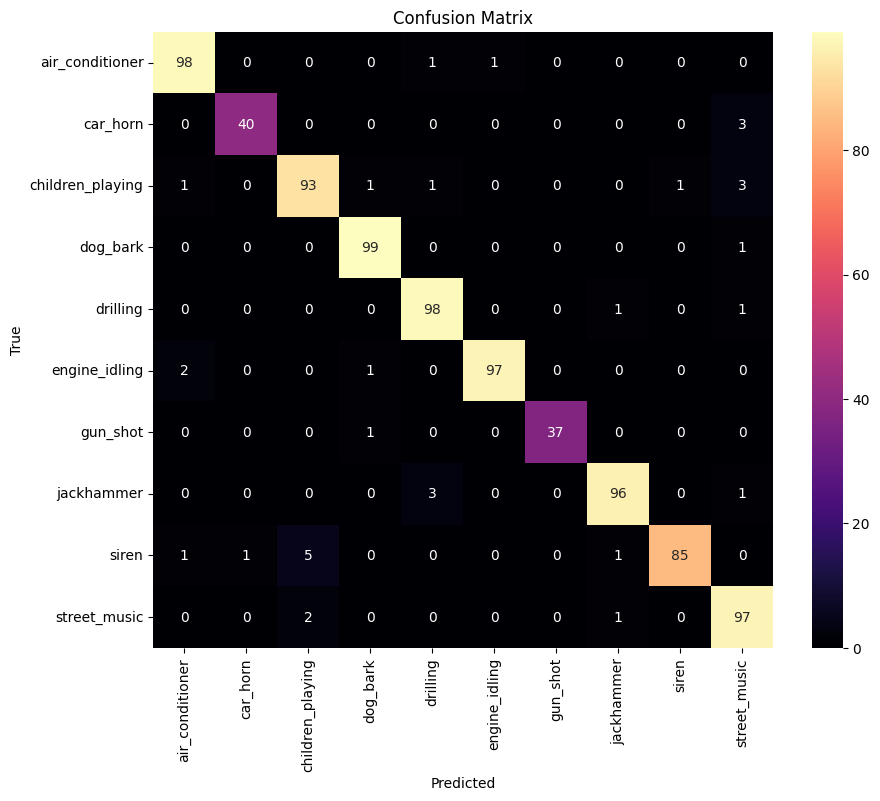

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generar la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="magma")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

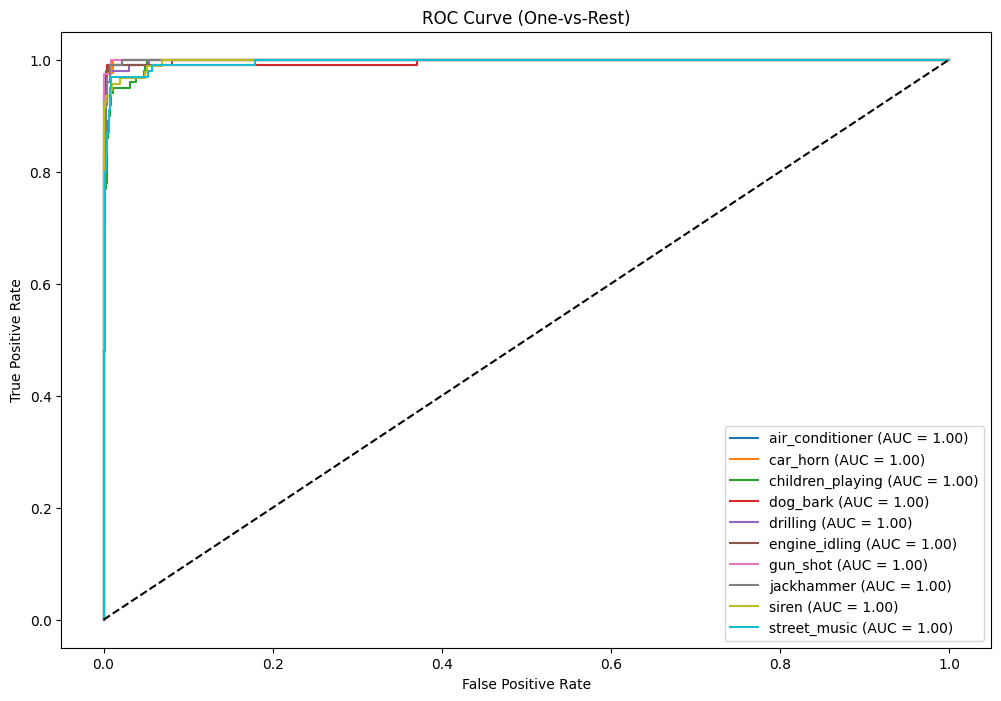

In [24]:
# ----------------------------------
# ROC y AUC (multiclase One-vs-Rest)
# ----------------------------------
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarizar etiquetas para multiclase
y_true_bin = label_binarize(y_true, classes=range(num_classes))
y_prob = np.array(y_prob)

plt.figure(figsize=(12,8))

# ROC por cada clase
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

# Baseline
plt.plot([0, 1], [0, 1], "k--")

plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [25]:
# AUC macro y micro
from sklearn.metrics import roc_auc_score

auc_macro = roc_auc_score(y_true_bin, y_prob, average="macro", multi_class="ovr")
auc_micro = roc_auc_score(y_true_bin, y_prob, average="micro", multi_class="ovr")

print("AUC Macro:", auc_macro)
print("AUC Micro:", auc_micro)

AUC Macro: 0.9982088177760987
AUC Micro: 0.998402445772176
